In [1]:
import json
import pandas as pd

with open('C:/Users/Acer/Documents/Fusemachines/LayoutLM/dataset/train.json') as f:
  data = json.load(f)

In [2]:
data.keys()

dict_keys(['qas'])

In [3]:
type(data)

dict

In [4]:
df = pd.DataFrame(data['qas'])
df.head()

,question_id,question,answers,image
0,1,what is Document Type?,[GRANT DEED],CA-Napa_CANAPA-2023_00009658.png
1,2,what is Recording Company?,[Fidelity National Title Company],CA-Napa_CANAPA-2023_00009658.png
2,3,what is Recording Document Number?,[2023-0009658],CA-Napa_CANAPA-2023_00009658.png
3,4,what is Recording Document Date?,[30-Jun-2023],CA-Napa_CANAPA-2023_00009658.png
4,5,what is APN?,[042-141-006-000],CA-Napa_CANAPA-2023_00009658.png


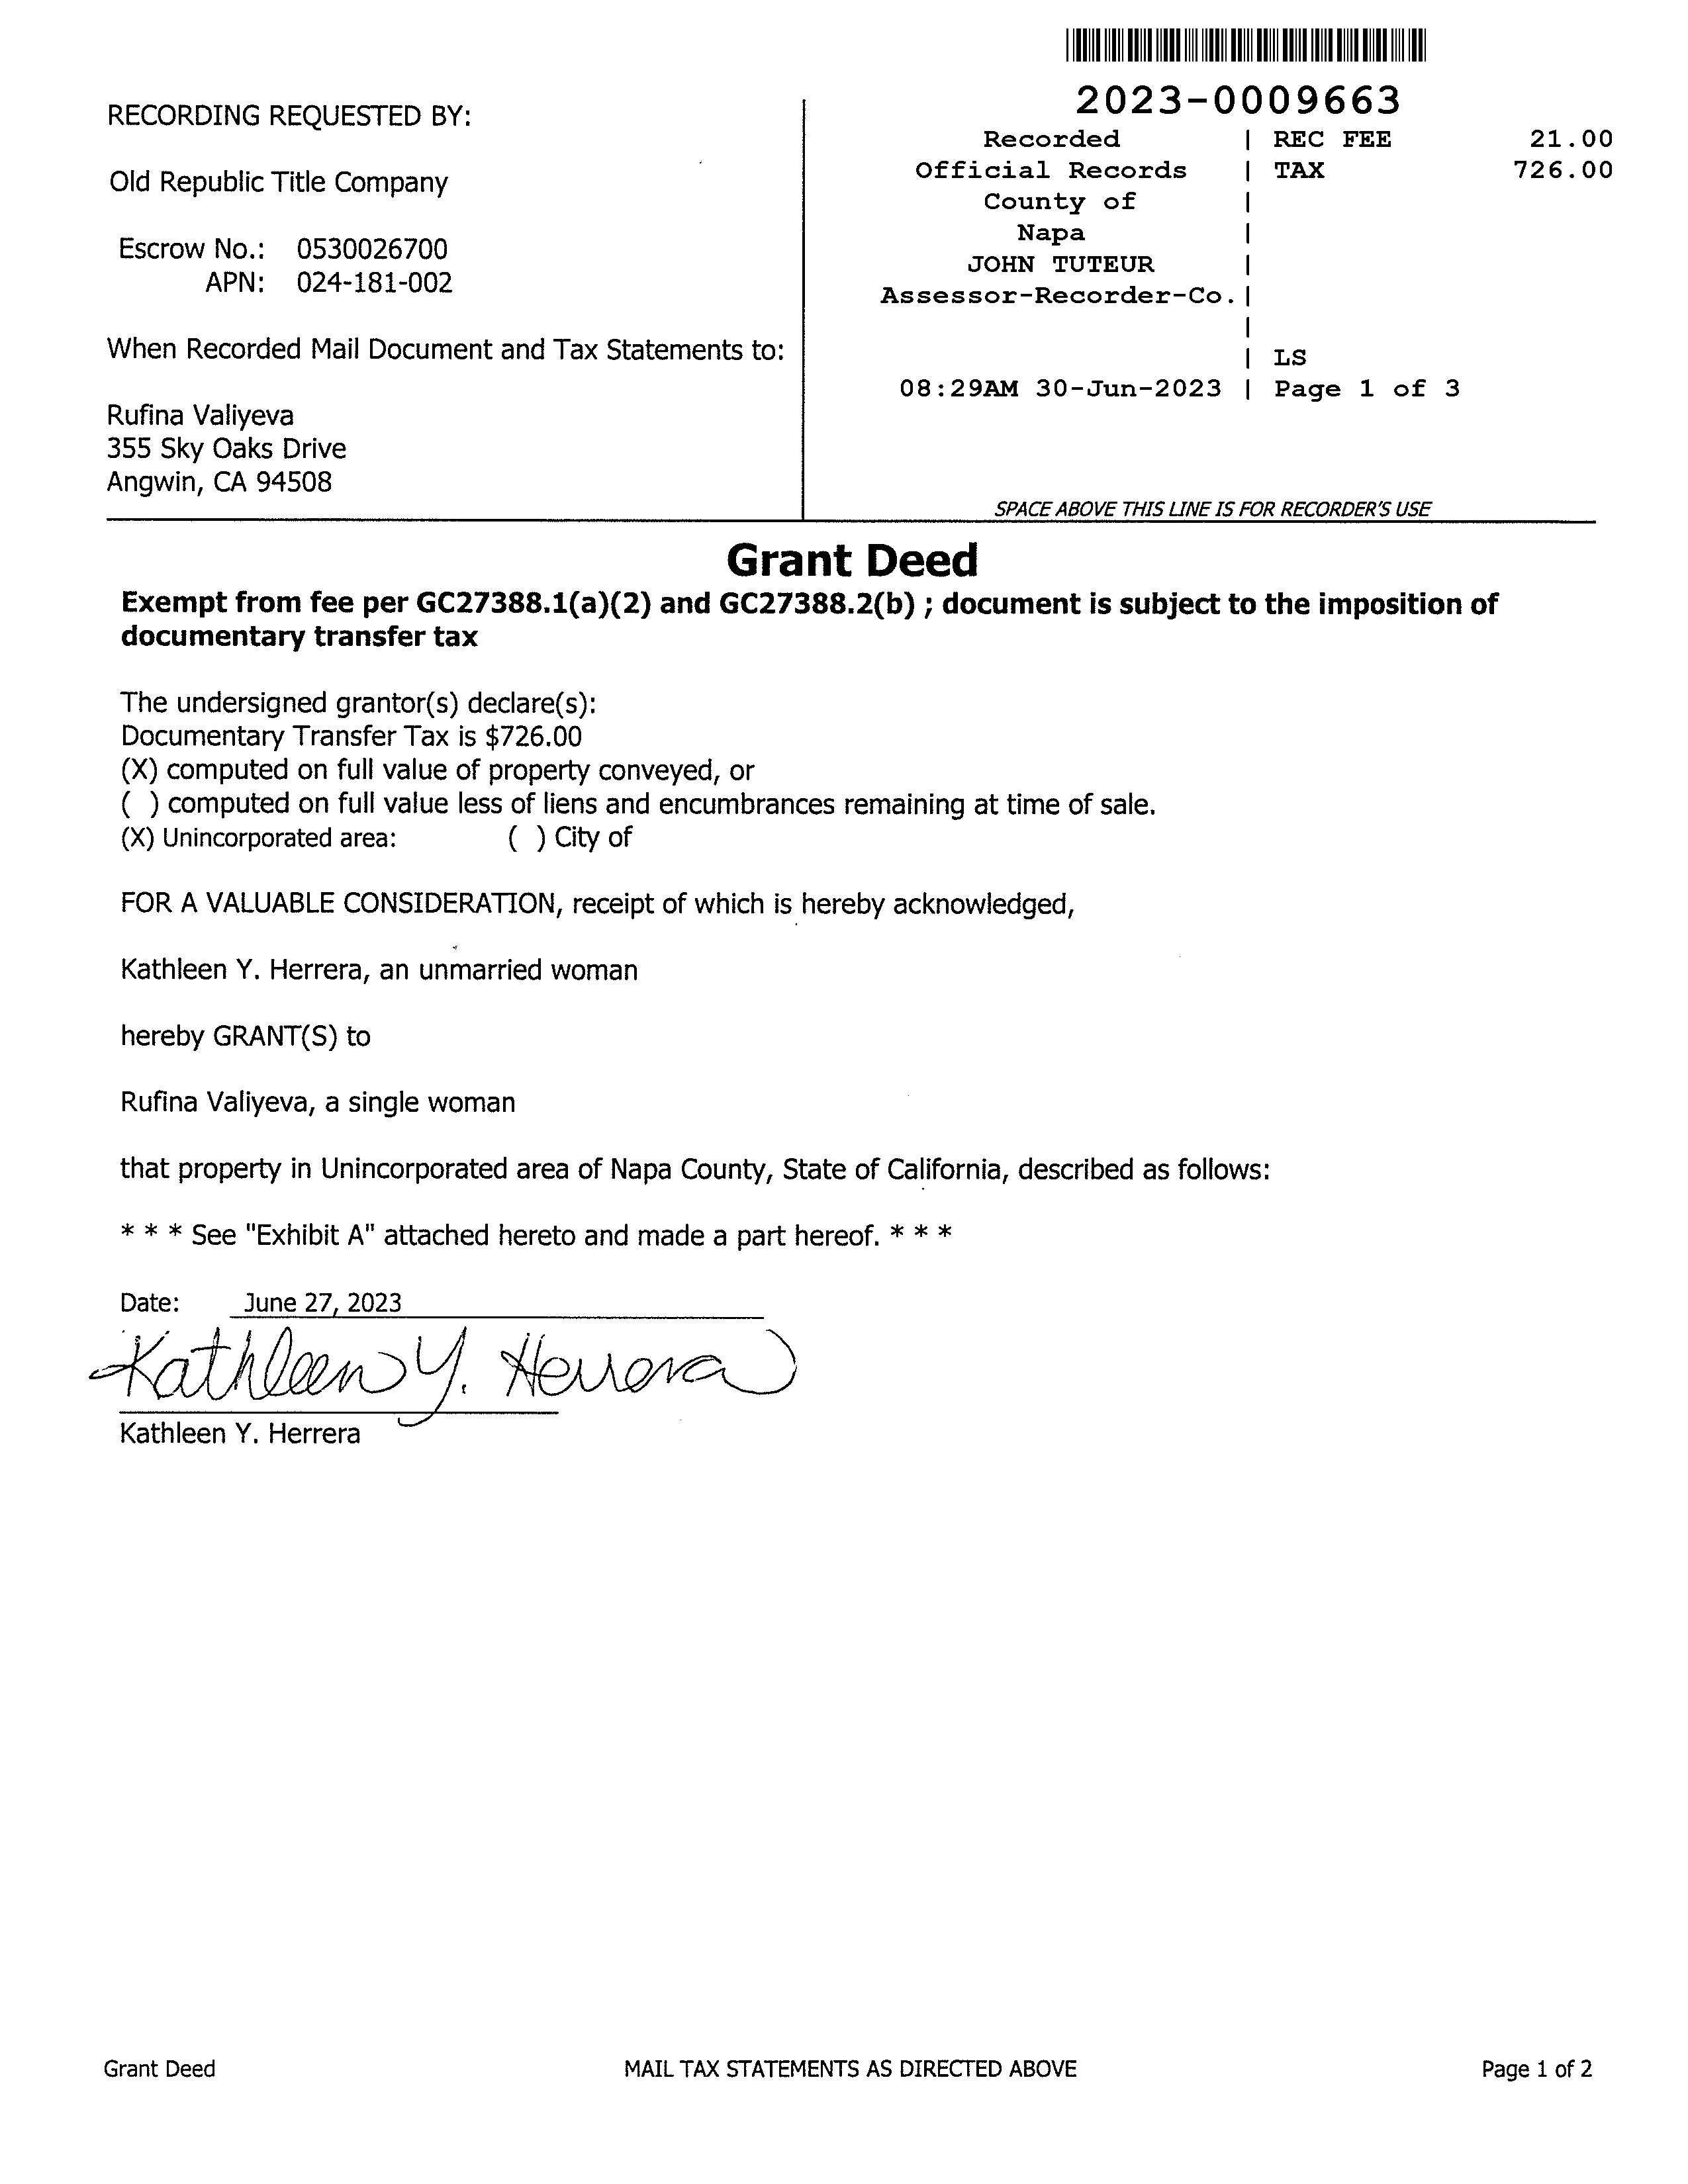

In [5]:
from PIL import Image

example = data['qas'][10]

root_dir = 'C:/Users/Acer/Documents/Fusemachines/LayoutLM/dataset/'
image = Image.open(root_dir + "documents/" + example['image'])
image

In [6]:
for k,v in example.items():
  print(k + ":", v)

question_id: 20
question: what is APN?
answers: ['024-181-002']
image: CA-Napa_CANAPA-2023_00009663.png


In [7]:
type(df['answers'])

pandas.core.series.Series

In [8]:
ocr_root_dir = root_dir + "ocr_result/"

with open(ocr_root_dir + example['image'] [:-3] + "json") as f:
  ocr = json.load(f)

In [9]:
ocr.keys()

dict_keys(['height', 'width', 'lines'])

In [10]:
words = ''
for item in ocr['lines']:
    words += item['text']

print(words)

UNDNAARECORDINGREQUESTEDBY:2023-0009663RecordedRECFEE21.00OldRepublicTitleCompanyOeCountyofTa726«OONapaEscrowNo.:0530026700JOHNTUTEURAPN:024-181-002Assessor-Recorder-Co.WhenRecordedMailDocumentandTaxStatementsto:LsPageof08:29AM30-Jun-2023RufinaValiyeva355SkyOaksDriveAngwin,CA94508SPACEABOVETHISLINEISFORRECORDER'SUSEGrantDeedExemptfromfeeperGC27388.1(a)(2)andGC27388.2(b)documentissubjecttotheimpositionofdocumentarytransfertaxTheundersignedgrantor(s)declare(s):DocumentaryTransferTaxis$726.00(X)computedonfullvalueofpropertyconveyed,orcomputedonfullvaluelessofliensandencumbrancesremainingattimeofsale.(X)Unincorporatedarea:(_CityofFORVALUABLECONSIDERATION,receiptofwhichisherebyacknowledged,KathleenY.Herrera,anunmarriedwomanherebyGRANT(S)toRufinaValiyeva,singlewomanthatpropertyinUnincorporatedareaofNapaCounty,StateofCalifornia,describedasfollows:See"ExhibitA"attachedheretoandmadeparthereof.Date:June27,2023KathleenY.HerreraGrantDeedMAILTAXSTATEMENTSASDIRECTEDABOVEPageof


In [11]:
from datasets import Dataset

dataset = Dataset.from_pandas(df.iloc[:50])

c:\Users\Acer\anaconda3\envs\layoutlmvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
dataset[0]

{'question_id': 1,
 'question': 'what is Document Type?',
 'answers': ['GRANT DEED'],
 'image': 'CA-Napa_CANAPA-2023_00009658.png'}

In [13]:
from transformers import LayoutLMv2FeatureExtractor

feature_extractor = LayoutLMv2FeatureExtractor()

def get_ocr_words_and_boxes(examples):
    
  images = [Image.open(root_dir + "documents/" + image_file).convert("RGB") for image_file in examples['image']]
  
  # resize every image to 224x224 + apply tesseract to get words + normalized boxes
  encoded_inputs = feature_extractor(images)

  examples['image'] = encoded_inputs.pixel_values
  examples['words'] = encoded_inputs.words
  examples['boxes'] = encoded_inputs.boxes

  return examples

c:\Users\Acer\anaconda3\envs\layoutlmvenv\Lib\site-packages\transformers\models\layoutlmv2\feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


In [14]:
dataset_with_ocr = dataset.map(get_ocr_words_and_boxes, batched=True, batch_size=2)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map: 100%|██████████| 50/50 [02:04<00:00,  2.49s/ examples]


In [15]:
print(dataset_with_ocr[0]['words'])
print(dataset_with_ocr[0]['boxes'])
print("-----")
print(dataset_with_ocr[5]['words'])
print(dataset_with_ocr[5]['boxes'])

['ANAT', 'A', 'AAA', '2023-0009658', 'Recorded', '|', 'REC', 'FEE', '21.00', 'Official', 'Records', '|', 'TAX', '1705.00', 'County', 'of', 'RECORDING', 'REQUESTED', 'BY:', 'Napa', 'Fidelity', 'National', 'Title', 'Company', 'JOHN', 'TUTEUR', 'LS', 'When', 'Recorded', 'Mail', 'Document', '08:16AM', '30-Jun-2023', '|', 'Page', '1', 'of', '3', 'and', 'Tax', 'Statement', 'To:', 'Warren', 'D.', 'Griess', 'and', 'Arleen', 'R.', 'Griess,', '1151', 'Rancho', 'Drive', 'Napa,', 'CA', '94558', '|', '|', '|', 'Assessor-Recorder-Co.', '|', '|', '|', '|', 'SPACE', 'ABOVE', 'THIS', 'LINE', 'FOR', "RECORDER'S", 'USE', 'Escrow', 'Order', 'No.:', 'FSNX-7012300464', 'Nl', 'S', '46', 'Exempt', 'from', 'fee', 'per', 'GC', '27388.1(a)(2);', 'This', 'document', 'is', 'a', 'transfer', 'that', 'is', 'subject', 'to', 'Property', 'Address:', '1151', 'Rancho', 'Drive,', 'Documentary', 'Transfer', 'Tax.', 'Napa,', 'CA', '94558', 'APN/Parcel', 'ID(s):', '042-141-006-000', 'GRANT', 'DEED', 'The', 'undersigned', 'gra

In [16]:
dataset_with_ocr[0].keys()

dict_keys(['question_id', 'question', 'answers', 'image', 'words', 'boxes'])

In [17]:
def subfinder(words_list, answer_list):  
    matches = []
    start_indices = []
    end_indices = []
    for idx, i in enumerate(range(len(words_list))):
        if words_list[i] == answer_list[0] and words_list[i:i+len(answer_list)] == answer_list:
            matches.append(answer_list)
            start_indices.append(idx)
            end_indices.append(idx + len(answer_list) - 1)
    if matches:
      return matches[0], start_indices[0], end_indices[0]
    else:
      return None, 0, 0

In [18]:
question = "where is it located?"
words = ["this", "is", "located", "in", "the", "university", "of", "california", "in", "the", "US"]
boxes = [[1000,1000,1000,1000] for _ in range(len(words))]
answer = "university of california"

In [19]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 16

In [20]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [21]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [22]:
encoding = tokenizer(question, words, boxes=boxes)

In [23]:
tokenizer.decode(encoding.input_ids)

'[CLS] where is it located? [SEP] this is located in the university of california in the us [SEP]'

In [24]:
print(encoding.word_ids())

[None, 0, 1, 2, 3, 3, None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]


In [25]:
print(encoding.sequence_ids())

[None, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


In [26]:
match, word_idx_start, word_idx_end = subfinder(words, answer.split())

In [27]:
print("Match:", match)
print("Word idx start:", word_idx_start)
print("Word idx end:", word_idx_end)

Match: ['university', 'of', 'california']
Word idx start: 5
Word idx end: 7


In [28]:
sequence_ids = encoding.sequence_ids()

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(encoding.input_ids) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

print("Token start index:", token_start_index)
print("Token end index:", token_end_index)
print(tokenizer.decode(encoding.input_ids[token_start_index:token_end_index+1]))

word_ids = encoding.word_ids()[token_start_index:token_end_index+1]
print("Word ids:", word_ids)
for id in word_ids:
  if id == word_idx_start:
    start_position = token_start_index 
  else:
    token_start_index += 1

for id in word_ids[::-1]:
  if id == word_idx_end:
    end_position = token_end_index 
  else:
    token_end_index -= 1

print(start_position)
print(end_position)
print("Reconstructed answer:", tokenizer.decode(encoding.input_ids[start_position:end_position+1]))

Token start index: 7
Token end index: 17
this is located in the university of california in the us
Word ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
12
14
Reconstructed answer: university of california


In [29]:
def encode_dataset(examples, max_length=512):
  # take a batch 
  questions = examples['question']
  words = examples['words']
  boxes = examples['boxes']

  # encode it
  encoding = tokenizer(questions, words, boxes, max_length=max_length, padding="max_length", truncation=True)

  # next, add start_positions and end_positions
  start_positions = []
  end_positions = []
  answers = examples['answers']
  # for every example in the batch:
  for batch_index in range(len(answers)):
    print("Batch index:", batch_index)
    cls_index = encoding.input_ids[batch_index].index(tokenizer.cls_token_id)
    # try to find one of the answers in the context, return first match
    words_example = [word.lower() for word in words[batch_index]]
    for answer in answers[batch_index]:
      match, word_idx_start, word_idx_end = subfinder(words_example, answer.lower().split())
      if match:
        break
    # EXPERIMENT (to account for when OCR context and answer don't perfectly match):
    if not match:
      for answer in answers[batch_index]:
        for i in range(len(answer)):
          # drop the ith character from the answer
          answer_i = answer[:i] + answer[i+1:]
          # check if we can find this one in the context
          match, word_idx_start, word_idx_end = subfinder(words_example, answer_i.lower().split())
          if match:
            break
    # END OF EXPERIMENT 
    
    if match:
      sequence_ids = encoding.sequence_ids(batch_index)
      # Start token index of the current span in the text.
      token_start_index = 0
      while sequence_ids[token_start_index] != 1:
          token_start_index += 1

      # End token index of the current span in the text.
      token_end_index = len(encoding.input_ids[batch_index]) - 1
      while sequence_ids[token_end_index] != 1:
          token_end_index -= 1
      
      word_ids = encoding.word_ids(batch_index)[token_start_index:token_end_index+1]
      for id in word_ids:
        if id == word_idx_start:
          start_positions.append(token_start_index)
          break
        else:
          token_start_index += 1

      for id in word_ids[::-1]:
        if id == word_idx_end:
          end_positions.append(token_end_index)
          break
        else:
          token_end_index -= 1
      
      print("Verifying start position and end position:")
      print("True answer:", answer)
      start_position = start_positions[batch_index]
      end_position = end_positions[batch_index]
      reconstructed_answer = tokenizer.decode(encoding.input_ids[batch_index][start_position:end_position+1])
      print("Reconstructed answer:", reconstructed_answer)
      print("-----------")
    
    else:
      print("Answer not found in context")
      print("-----------")
      start_positions.append(cls_index)
      end_positions.append(cls_index)
  
  encoding['image'] = examples['image']
  encoding['start_positions'] = start_positions
  encoding['end_positions'] = end_positions

  return encoding

In [30]:
type(dataset_with_ocr['answers'])

list

In [31]:
from datasets import Features, Sequence, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'start_positions': Value(dtype='int64'),
    'end_positions': Value(dtype='int64'),
})

encoded_dataset = dataset_with_ocr.map(encode_dataset, batched=True, batch_size=2, 
                                       remove_columns=dataset_with_ocr.column_names,
                                       features=features)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Batch index: 0
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------
Batch index: 1
Verifying start position and end position:
True answer: Fidelity National Title Company
Reconstructed answer: fidelity national title company
-----------


Map:   4%|▍         | 2/50 [00:00<00:06,  7.85 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 2023-0009658
Reconstructed answer: 2023 - 0009658
-----------
Batch index: 1
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30 - jun - 2023
-----------


Map:   8%|▊         | 4/50 [00:00<00:05,  8.66 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 042-141-006-000
Reconstructed answer: 042 - 141 - 006 - 000
-----------
Batch index: 1
Verifying start position and end position:
True answer: Warren D. Griess and Arleen R. Griess
Reconstructed answer: warren d. griess and arleen r. griess
-----------


Map:  12%|█▏        | 6/50 [00:00<00:05,  7.35 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: Grant Deed
Reconstructed answer: grant deed
-----------
Batch index: 1
Verifying start position and end position:
True answer: Old Republic Title Company
Reconstructed answer: old republic title company
-----------


Map:  16%|█▌        | 8/50 [00:01<00:05,  7.75 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 2023-0009663
Reconstructed answer: 2023 - 0009663
-----------
Batch index: 1
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30 - jun - 2023
-----------


Map:  20%|██        | 10/50 [00:01<00:05,  7.25 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 024-181-002
Reconstructed answer: 024 - 181 - 002
-----------
Batch index: 1
Verifying start position and end position:
True answer: Rufina Valiyeva
Reconstructed answer: rufina valiyeva
-----------


Map:  28%|██▊       | 14/50 [00:01<00:04,  7.53 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------
Batch index: 1
Verifying start position and end position:
True answer: First American Title Company
Reconstructed answer: first american title company
-----------
Batch index: 0
Verifying start position and end position:
True answer: 2023-0009683
Reconstructed answer: 2023 - 0009683
-----------
Batch index: 1
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30 - jun - 2023
-----------


Map:  32%|███▏      | 16/50 [00:02<00:04,  7.19 examples/s]

Batch index: 0
Answer not found in context
-----------
Batch index: 1
Answer not found in context
-----------


Map:  36%|███▌      | 18/50 [00:02<00:04,  6.85 examples/s]

Batch index: 0
Answer not found in context
-----------
Batch index: 1
Verifying start position and end position:
True answer: Book 29
Reconstructed answer: book 29
-----------


Map:  44%|████▍     | 22/50 [00:03<00:04,  6.74 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: Lot 21
Reconstructed answer: lot 21
-----------
Batch index: 1
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------
Batch index: 0
Verifying start position and end position:
True answer: Fidelity National Title Company
Reconstructed answer: fidelity national title company
-----------
Batch index: 1
Verifying start position and end position:
True answer: 2023-0009704
Reconstructed answer: 2023 - 0009704
-----------


Map:  48%|████▊     | 24/50 [00:03<00:03,  7.39 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30 - jun - 2023
-----------
Batch index: 1
Verifying start position and end position:
True answer: 004-372-005-000
Reconstructed answer: 004 - 372 - 005 - 000
-----------


Map:  52%|█████▏    | 26/50 [00:03<00:03,  7.92 examples/s]

Batch index: 0
Answer not found in context
-----------
Batch index: 1
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------


Map:  56%|█████▌    | 28/50 [00:03<00:02,  8.21 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: MANFRED & HUNT, LLP
Reconstructed answer: manfred & hunt, llp
-----------
Batch index: 1
Verifying start position and end position:
True answer: 2023-0009708
Reconstructed answer: 2023 - 0009708
-----------


Map:  60%|██████    | 30/50 [00:03<00:02,  8.55 examples/s]

Batch index: 0
Answer not found in context
-----------
Batch index: 1
Verifying start position and end position:
True answer: 043-280-005
Reconstructed answer: 043 - 280 - 005
-----------


Map:  68%|██████▊   | 34/50 [00:04<00:01,  8.96 examples/s]

Batch index: 0
Answer not found in context
-----------
Batch index: 1
Verifying start position and end position:
True answer: Pages 11
Reconstructed answer: pages 11
-----------
Batch index: 0
Verifying start position and end position:
True answer: Book 13
Reconstructed answer: book 13
-----------
Batch index: 1
Verifying start position and end position:
True answer: Lot 121
Reconstructed answer: lot 121
-----------


Map:  76%|███████▌  | 38/50 [00:04<00:01,  8.76 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------
Batch index: 1
Verifying start position and end position:
True answer: Kirkland & Ellis LLP
Reconstructed answer: kirkland & ellis llp
-----------
Batch index: 0
Verifying start position and end position:
True answer: 2023-0009716
Reconstructed answer: 2023 - 0009716
-----------
Batch index: 1
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30 - jun - 2023
-----------


Map:  84%|████████▍ | 42/50 [00:05<00:01,  7.32 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 033-340-017
Reconstructed answer: 033 - 340 - 017
-----------
Batch index: 1
Answer not found in context
-----------
Batch index: 0
Verifying start position and end position:
True answer: GRANT DEED
Reconstructed answer: grant deed
-----------
Batch index: 1
Verifying start position and end position:
True answer: First American Title Company of Napa
Reconstructed answer: first american title company of napa
-----------


Map:  92%|█████████▏| 46/50 [00:05<00:00,  7.62 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 2023-0009718
Reconstructed answer: 2023 - 0009718
-----------
Batch index: 1
Verifying start position and end position:
True answer: 30-Jun-2023
Reconstructed answer: 30jun - 2023
-----------


Map:  96%|█████████▌| 48/50 [00:06<00:00,  7.79 examples/s]

Batch index: 0
Verifying start position and end position:
True answer: 001-091-024
Reconstructed answer: 001 - 091 - 024
-----------
Batch index: 1
Verifying start position and end position:
True answer: MENTIS
Reconstructed answer: mentis
-----------
Batch index: 0
Verifying start position and end position:
True answer: LOT 45
Reconstructed answer: lot 45
-----------
Batch index: 1
Answer not found in context
-----------


Map: 100%|██████████| 50/50 [00:06<00:00,  7.75 examples/s]


In [32]:
encoded_dataset

Dataset({
    features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'image', 'start_positions', 'end_positions'],
    num_rows: 50
})

In [33]:
encoded_dataset

Dataset({
    features: ['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'image', 'start_positions', 'end_positions'],
    num_rows: 50
})

In [34]:
idx = 44

tokenizer.decode(encoded_dataset['input_ids'][idx])

'[CLS] what is recording document number? [SEP] fave eau or 2023 - 0009718 recording requested by recorded rec fee 21. 00 oral eeccess first american title company of napa news john tuteur and when recorded mail to assesser - resneder - gos ms q any p i of 3 name mentis 12 : 37pm 30jun - 2023 age a street 709 franklin st. address civ. site, napa, ca 94559 order no. 00302646b space above this line for recorder ’ s use grant deed the undersigned grantor ( s ) declare ( s ) documentary transfer tax is $ 0. 00 ( exempt ) r & t 11925 apn ( s ) 001 - 091 - 024 o computed on full value of interest or property conveyed, or c1 ) full value less value of liens or encumbrances remaining at the time of sale m1 city of napa for a valuable consideration, receipt of which is hereby acknowledged, mentis, a corporation, who acquired title as family service of the north bay, a california non - profit corporation hereby grant ( s ) to mentis, a california nonprofit public benefit corporation the followin

In [35]:
dataset['image'][idx]

'CA-Napa_CANAPA-2023_00009718.png'

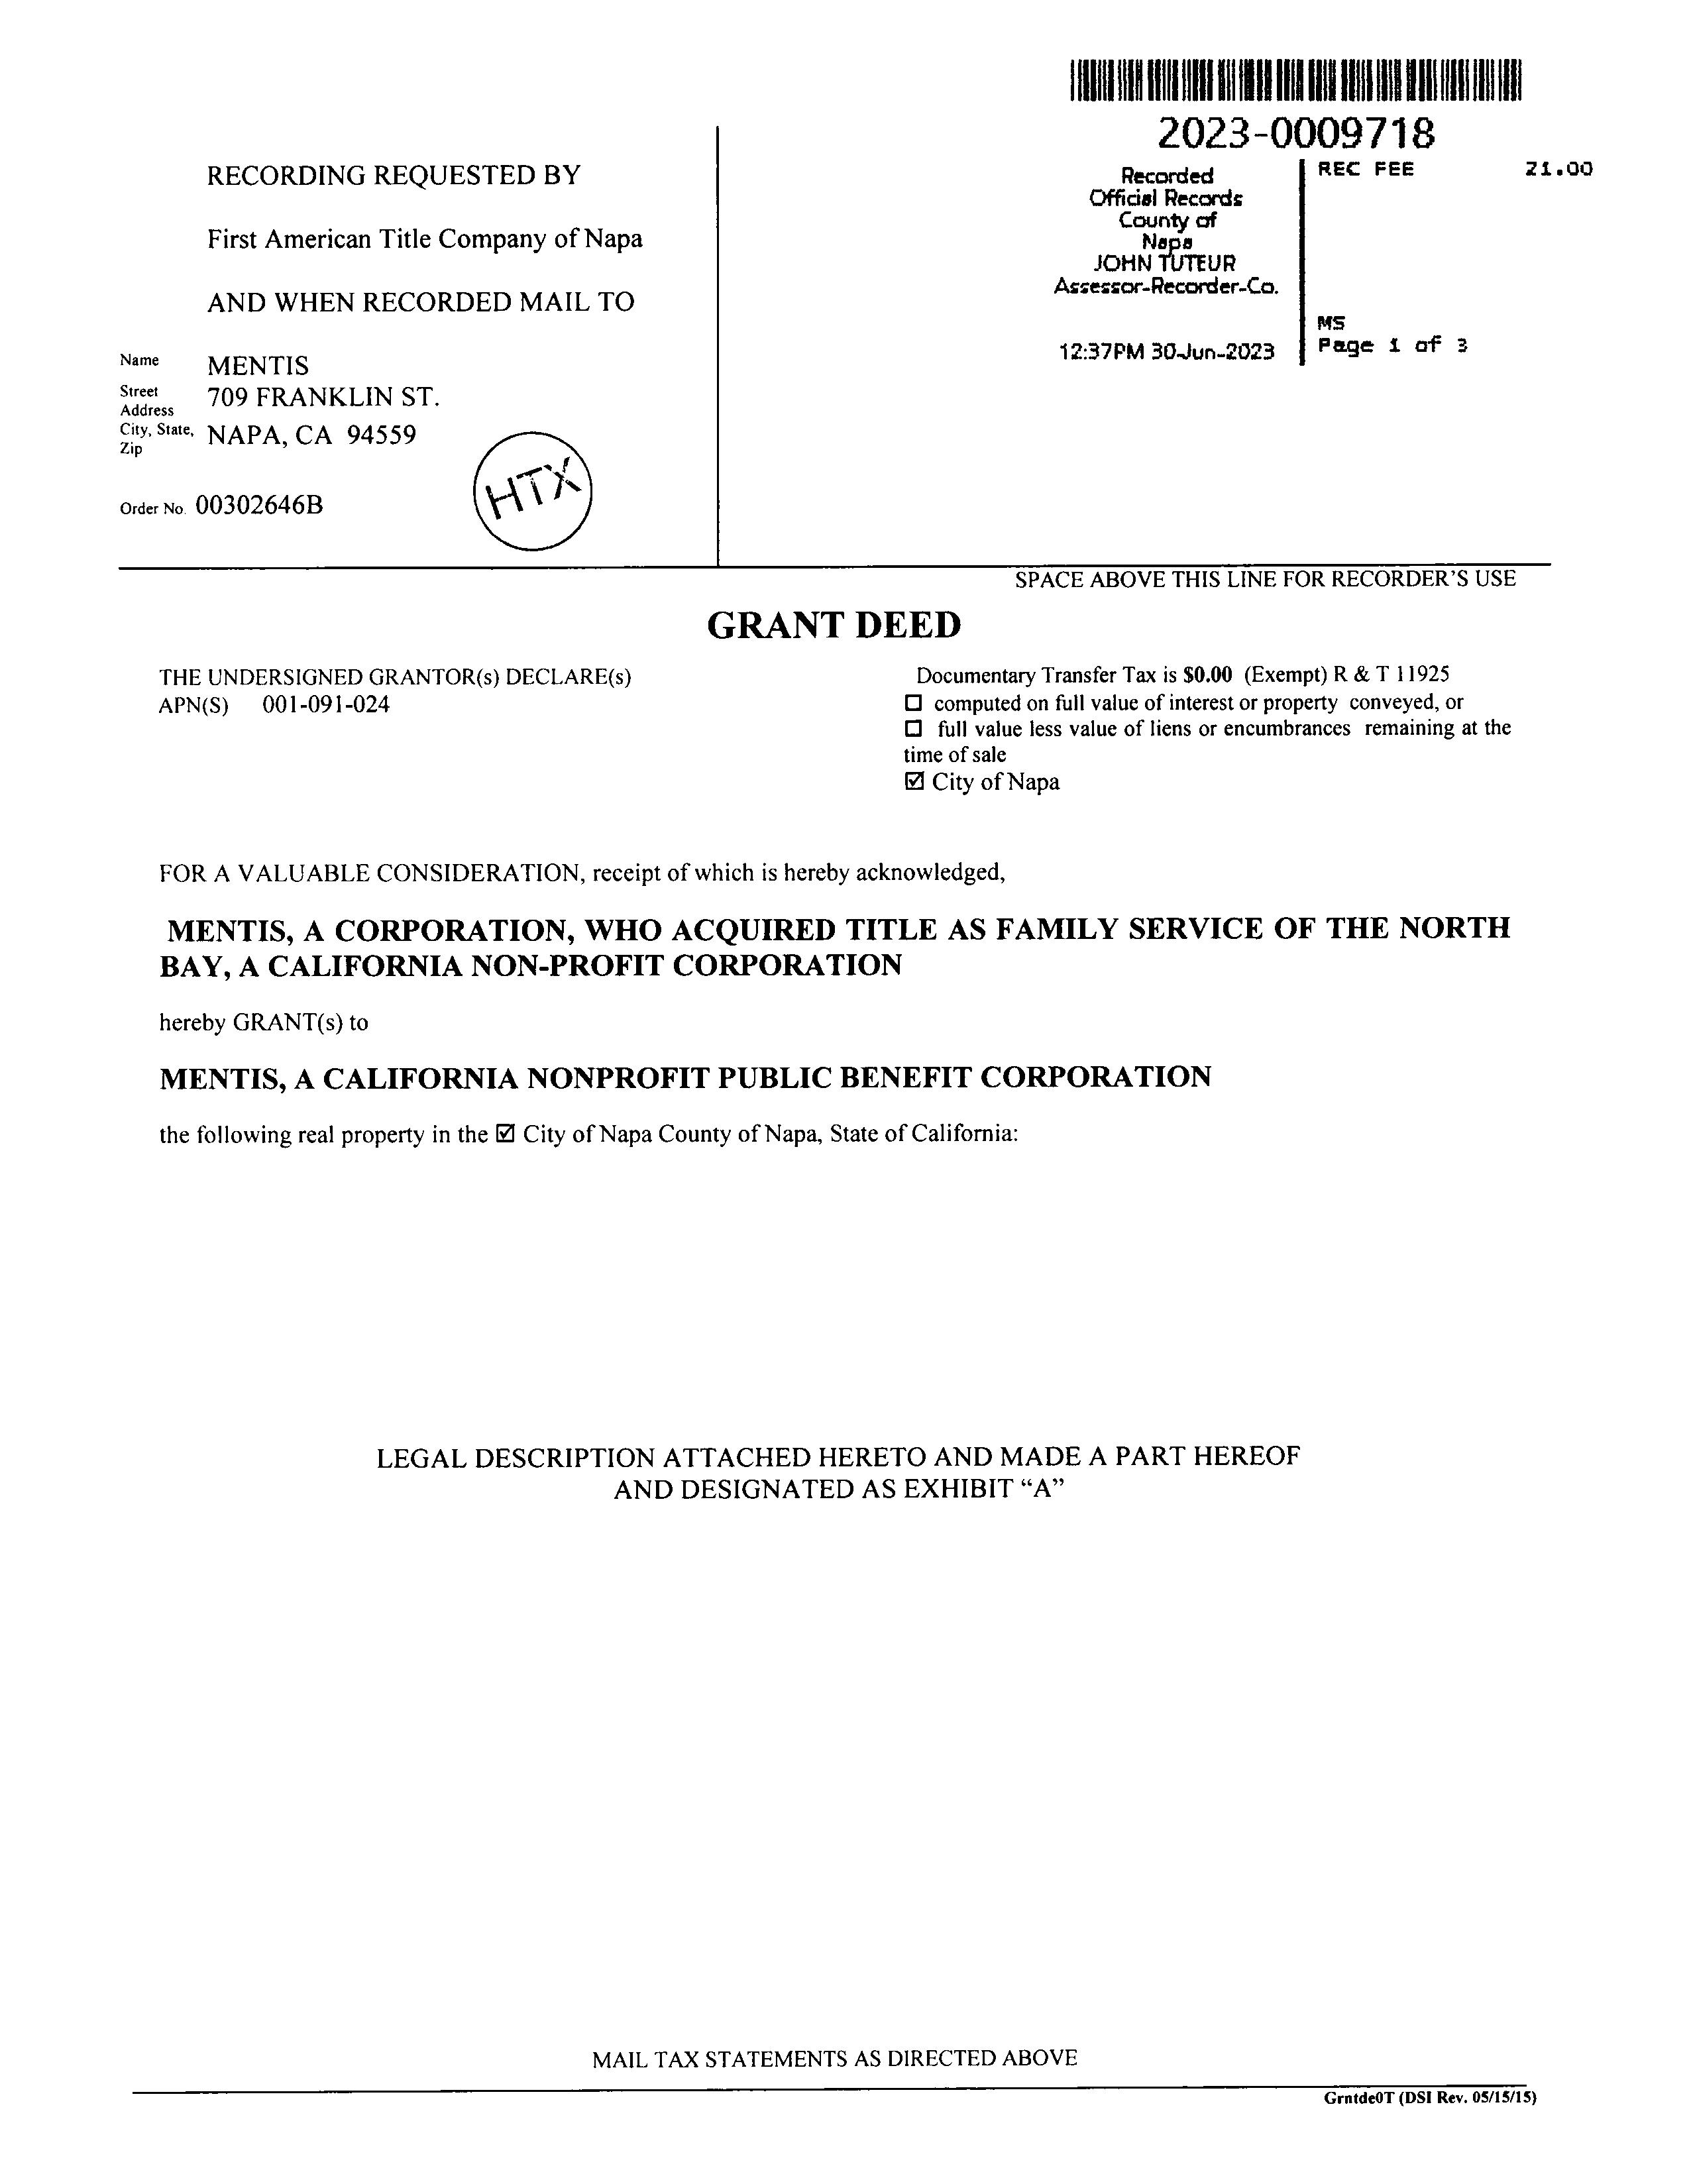

In [36]:
image = Image.open('C:/Users/Acer/Documents/Fusemachines/LayoutLM/dataset/documents/' + dataset['image'][idx])
image

In [37]:
start_position = encoded_dataset['start_positions'][idx]
end_position = encoded_dataset['end_positions'][idx]
if start_position != 0:
  print(tokenizer.decode(encoded_dataset['input_ids'][idx][start_position: end_position+1]))
else:
  print("Answer not found in context")

2023 - 0009718


In [38]:
len(encoded_dataset)

50

In [39]:
encoded_dataset.features

{'input_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'bbox': Array2D(shape=(512, 4), dtype='int64', id=None),
 'attention_mask': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'image': Array3D(shape=(3, 224, 224), dtype='int64', id=None),
 'start_positions': Value(dtype='int64', id=None),
 'end_positions': Value(dtype='int64', id=None)}

In [40]:
import torch

encoded_dataset.set_format(type="torch")
dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
image torch.Size([4, 3, 224, 224])
start_positions torch.Size([4])
end_positions torch.Size([4])


In [41]:
idx = 2

tokenizer.decode(batch['input_ids'][2])

'[CLS] what is recording document number? [SEP] anat a aaa 2023 - 0009658 recorded | rec fee 21. 00 official records | tax 1705. 00 county of recording requested by : napa fidelity national title company john tuteur ls when recorded mail document 08 : 16am 30 - jun - 2023 | page 1 of 3 and tax statement to : warren d. griess and arleen r. griess, 1151 rancho drive napa, ca 94558 | | | assessor - recorder - co. | | | | space above this line for recorder\'s use escrow order no. : fsnx - 7012300464 nl s 46 exempt from fee per gc 27388. 1 ( a ) ( 2 ) ; this document is a transfer that is subject to property address : 1151 rancho drive, documentary transfer tax. napa, ca 94558 apn / parcel id ( s ) : 042 - 141 - 006 - 000 grant deed the undersigned grantor ( s ) declare ( s ) o this transfer is exempt from the documentary transfer tax. mi the documentary transfer tax is $ 1, 705. 00 and is computed on : the full value of the interest or property conveyed. c the full value less the liens or 

In [42]:
start_position = batch['start_positions'][idx].item()
end_position = batch['end_positions'][idx].item()

tokenizer.decode(batch['input_ids'][idx][start_position:end_position+1])

'2023 - 0009658'

In [43]:
model_checkpoint = "microsoft/layoutlmv2-base-uncased"
batch_size = 16

In [44]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

c:\Users\Acer\anaconda3\envs\layoutlmvenv\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\Acer\anaconda3\envs\layoutlmvenv\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Some weights of LayoutLMv2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['layoutlmv2.visual_segment_embedding', 'qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(20):  # loop over the dataset multiple times
   for idx, batch in enumerate(dataloader):
        # get the inputs;
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        bbox = batch["bbox"].to(device)
        image = batch["image"].to(device)
        start_positions = batch["start_positions"].to(device)
        end_positions = batch["end_positions"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                       bbox=bbox, image=image, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

c:\Users\Acer\anaconda3\envs\layoutlmvenv\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Loss: 6.245140075683594
Loss: 6.24925422668457
Loss: 6.1637163162231445
Loss: 6.036060333251953
Loss: 6.2166547775268555
Loss: 5.975975036621094
Loss: 5.965182304382324
Loss: 5.935624122619629
Loss: 6.0863938331604
Loss: 5.713127613067627
Loss: 5.720980167388916
Loss: 5.600113391876221
Loss: 5.785351753234863
Loss: 5.413821220397949
Loss: 5.594992637634277
Loss: 5.133309364318848
Loss: 5.099974632263184
Loss: 5.306059837341309
Loss: 4.982330799102783
Loss: 4.888637542724609
Loss: 4.8870158195495605
Loss: 4.954538345336914
Loss: 4.551721572875977
Loss: 4.6879682540893555
Loss: 4.406125068664551
Loss: 4.6027421951293945
Loss: 4.233583927154541
Loss: 5.174217224121094
Loss: 4.193729400634766
Loss: 4.274009704589844
Loss: 4.46563720703125
Loss: 4.168525695800781
Loss: 4.12448787689209
Loss: 4.149589538574219
Loss: 4.568869113922119
Loss: 3.9291772842407227
Loss: 4.086633682250977
Loss: 3.9285855293273926
Loss: 4.152186393737793
Loss: 3.874512195587158
Loss: 4.472742080688477
Loss: 3.853192